> **前言：** 学习了 Sutton 的《强化学习（第二版）》第6章时序差分学习的控制部分，将笔记提炼如下。

笔者阅读的是中文书籍，所提到的公式，笔者将给出其在英文书籍上的页码。英文书籍见 Sutton 个人主页：
[http://incompleteideas.net/book/the-book.html](http://incompleteideas.net/book/the-book.html)

本次笔记内容：

- 6.4 Sarsa：同轨策略下的时序差分控制
- 6.5 Q 学习：离轨策略下的时序差分控制
- 6.6 期望 Sarsa
- 6.7 最大化偏差与双学习
- 6.8 游戏、后位状态和其他特殊例子
- 6.9 本章小结

在上一次笔记中，我们讨论了 [动态规划（ Dynamic Programming, DP ）、蒙特卡洛方法（ Monte Carlo Method, MC ）与时序差分学习（ Temporal Difference Learning, TD ）的异同](https://blog.csdn.net/weixin_42815609/article/details/104034967)，以及时序差分学习中的预测算法。本次笔记中我们讨论其控制部分算法，其概述如下。

- Sarsa 是同轨策略下的时序差分控制，；
- Q-learning 是离轨策略下的时序差分控制；
- 期望 Sarsa 的表现比上述二者表现都更好（ van Hasselt, 2011），并且被称为“广义 Q 学习”；
- 然而，单纯的最大化操作带来了“最大化偏差”，因此我们提出“双学习”来消除“最大化偏差”；
- 此外，我们还引出了如“后位状态”的概念，没有具体讨论。

书中展示了4段实例， Zhang 都有相应代码进行实现，分别介绍如下知识点：
- 有风的网格世界（Example 6.5: Windy Gridworld）介绍 Sarsa 的性能；
- 在悬崖边行走（Example 6.6: Cliff Walking）对比了基于$\epsilon$-贪心方法的 Sarsa 与 Q-learning 的控制效果；
- 接着，在介绍 期望 Sarsa 时也使用了 Cliff Walking 实例对其效果进行展示；
- 最大化偏差实例（Example 6.7: Maximization Bias Example）用于表达：双 Q 学习优于 Q 学习。

我对其代码进行了标注，请见[https://github.com/PiperLiu/Reinforcement-Learning-practice-zh/blob/master/practice/05-02-Temporal-Difference-Control.ipynb](https://github.com/PiperLiu/Reinforcement-Learning-practice-zh/blob/master/practice/05-02-Temporal-Difference-Control.ipynb)。**并且，我还由代码及实验结果，复述了我对于书上提出的算法对比特性的理解。**

### Sarsa

基于同轨策略，其更新公式为：

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [ R_{t+1} + \gamma Q( S_{t+1}, A_{t+1} ) - Q_(S_t , A_t ) ]$$

可以看出与之前“时序差分预测”中的价值预测公式很像。

如果 $S_{t+1}$ 是终止状态，那么$Q( S_{t+1}, A_{t+1}$则定义为0。这个公式用到了元组$(S_t,A_t,R_{t+1},S_{t+1},A_{t+1})$，因此该算法命名为 Sarsa 。

Sarsa 想要以1的概率收敛到最优的策略和动作价值函数，需要满足2个条件：
1. 所有的“状态-动作”二元组都被无限多次访问到；
2. 贪心策略在极限情况下能够收敛（收敛过程可以通过令 $\epsilon = 1/t$ 来实现）。

算法框架中，每幕中的每步都要更新 Q ，不具体展示框架了，可见书第6章。

### Q-learning

更新公式为：

$$Q(S_t,A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)]$$

只是变了个更新公式而已，连算法框图都没变，**为什么说 Q-learning 是离轨策略呢？**
- 书上的解释：In this case, the learned action-value function, Q, directly approximates q*, the optimal action-value function, independent of the policy being followed.
- 我的理解：在公式中用于更新的动作为 $\argmax_a Q(S' , a)$ ，而下一步却未必是 $\argmax_a Q(S' , a)$ ，因此为离轨策略。

**我的理解方式没有错，并且，这个理解会辅助对于“最大化偏差”部分的学习。**

### 期望 Sarsa

$$\begin{aligned}Q(S_t, A_t) & \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \mathbb{E}[ Q(S_{t+1}, A_{t+1}) | S_{t+1}] - Q(S_t, A_t)]\\
& \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \sum_a \pi(a | S_{t+1}) Q(S_{t+1},a) - Q(S_t, A_t)]\\\end{aligned}$$

虽然计算上更为复杂，但它消除了 Sarsa 中因为随机选择 $A_{t+1}$ 而带来的方差。并且，对于 cliff walking 中的情况，期望 Sarsa 将保持 Sarsa 相对于 Q-learning 的“能学到迂回策略”的优势。

### 最大化偏差与双学习

#### 最大化偏差

上述算法中，通常是基于 $\epsilon-$贪心 来产生策略的，这其中都用到了“最大化操作”。

**但是，如果在估计值的基础上进行最大化操作，就是隐式地对最大值进行估计，而这就会产生一个显著的正偏差。例子如下。**

![](images/05-05.png)

如图的MDP，A为起点，做动作 left ，则0收益；做动作 right ，之后获得的收益服从 正态分布 N(-0.1, 1)。

我们知道最优策略应该是 100% 做动作 left 。

但是，如果使用了最大化操作，动作 right 的估计值是不确定的，有些可能大于0，则估计值的最大值就产生了正数，就产生了正偏差。**就是最大化偏差。**

#### 双学习

双学习可以消除最大化偏差。双学习使用了2倍的内存，但计算量无需双倍。

**以双Q学习为例：**

使用 $Q1$ 来估计 $A^* = \argmax_a Q_1(a)$ ，而 $Q_2$ 负责估计 $Q_2(A^*) = Q_2(\argmax_a Q_1 (a))$ ，由于 $\mathbb{E} [Q_2 (A^*)] = q(A^*)$ ，因此这个估计是无偏的。

即更新公式换为：

$$\begin{aligned}
& With \; 0.5 \; probabilility: \\
& \quad  Q_1(S_t,A_t) \leftarrow Q_1(S_t, A_t) + \alpha [R_{t+1} + \gamma Q_2(S_{t+1}, \argmax_a Q_1(S_{t+1}, a)) - Q_1(S_t, A_t)] \\
& else: \\
& \quad  Q_2(S_t,A_t) \leftarrow Q_2(S_t, A_t) + \alpha [R_{t+1} + \gamma Q_1(S_{t+1}, \argmax_a Q_2(S_{t+1}, a)) - Q_2(S_t, A_t)] \\
\end{aligned}$$

### 后位状态

后位状态我读了两遍，差不多明白了其意思：类似下棋的游戏中，可以由不同的状态，经过不同的动作，达到同一状态（棋盘摆放位置同），我们叫这个为后位状态。在这种情况中，后位状态显然更为重要。这很有趣，应该找些实例继续了解。

Van Roy, Bertsekas, Lee, Tsitsiklis, 1997; Powell, 2011 对其进行了研究。


### Example 6.5: Windy Gridworld

![](/images/05-03.png)

Shown inset below is a standard gridworld, with start and goal states, but with one di↵erence: there is a crosswind running upward through the middle of the grid. The actions are the standard four—up, down, right, and left—but in the middle region the resultant next states are shifted upward by a “wind,” the strength of which varies from column to column. The strength of the wind is given below each column, in number of cells shifted upward. For example, if you are one cell to the right of the goal, then the action left takes you to the cell just above the goal. This is an undiscounted episodic task, with constant rewards of −1 until the goal state is reached.

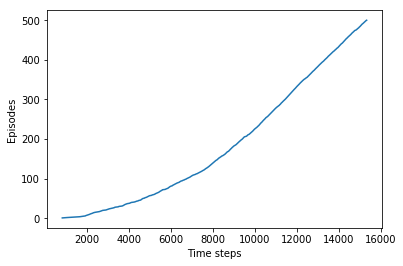

Optimal policy is:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
['R', 'R', 'R', 'U', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'L', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'U']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [2]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# world height
WORLD_HEIGHT = 7

# world width
WORLD_WIDTH = 10

# wind strength for each column
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probability for exploration
EPSILON = 0.1

# Sarsa step size
ALPHA = 0.5

# reward for each step
REWARD = -1.0

START = [3, 0]
GOAL = [3, 7]
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

def step(state, action):
    i, j = state
    if action == ACTION_UP:
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

# play for an episode
def episode(q_value):
    # track the total time steps in this episode
    time = 0

    # initialize state
    state = START

    # choose an action based on epsilon-greedy algorithm
    '''
    使用 np.random.binomial(1, EPSILON) 二项分布
    来生产随机数据，表示随机性，我认为要比 random < 值 要好
    '''
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        '''
        choice() 里 [] 的生成，使用了迭代器以及 if
        '''
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # keep going until get to the goal state
    while state != GOAL:
        next_state = step(state, action)
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # Sarsa update
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    return time

def figure_6_3():
    q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    episode_limit = 500

    steps = []
    ep = 0
    while ep < episode_limit:
        steps.append(episode(q_value))
        # time = episode(q_value)
        # episodes.extend([ep] * time)
        ep += 1

    steps = np.add.accumulate(steps)

    plt.plot(steps, np.arange(1, len(steps) + 1))
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')

    plt.show()

    # display the optimal policy
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    print('Optimal policy is:')
    for row in optimal_policy:
        print(row)
    print('Wind strength for each column:\n{}'.format([str(w) for w in WIND]))


figure_6_3()


### Example 6.6: Cliff Walking

This gridworld example compares Sarsa and Q-learning, highlighting the difference between on-policy (Sarsa) and o↵-policy (Q-learning) methods.

Consider the gridworld shown to the right. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all
transitions except those into the region marked “The Cliff.” Stepping
into this region incurs a reward of −100 and sends the agent instantly
back to the start.

![](images/05-04.png)

In [3]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (
        action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward

# reward for each action in each state
# actionRewards = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
# actionRewards[:, :, :] = -1.0
# actionRewards[2, 1:11, ACTION_DOWN] = -100.0
# actionRewards[3, 0, ACTION_RIGHT] = -100.0

# set up destinations for each action in each state
# actionDestination = []
# for i in range(0, WORLD_HEIGHT):
#     actionDestination.append([])
#     for j in range(0, WORLD_WIDTH):
#         destinaion = dict()
#         destinaion[ACTION_UP] = [max(i - 1, 0), j]
#         destinaion[ACTION_LEFT] = [i, max(j - 1, 0)]
#         destinaion[ACTION_RIGHT] = [i, min(j + 1, WORLD_WIDTH - 1)]
#         if i == 2 and 1 <= j <= 10:
#             destinaion[ACTION_DOWN] = START
#         else:
#             destinaion[ACTION_DOWN] = [min(i + 1, WORLD_HEIGHT - 1), j]
#         actionDestination[-1].append(destinaion)
# actionDestination[3][0][ACTION_RIGHT] = START

# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

# print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    for row in optimal_policy:
        print(row)

# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure_6_4():
    # episodes of each run
    episodes = 500

    # perform 40 independent runs
    runs = 50
    '''
    runs 求平均之用
    防止一次计算带来的误差
    多次计算
    '''

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_q_learning = np.copy(q_sarsa)
        for i in range(0, episodes):
            # cut off the value by -100 to draw the figure more elegantly
            # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
            # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
            rewards_sarsa[i] += sarsa(q_sarsa)
            rewards_q_learning[i] += q_learning(q_q_learning)

    # averaging over independt runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim([-100, 0])
    plt.legend()

    plt.show()

    # display optimal policy
    print('Sarsa Optimal Policy:')
    print_optimal_policy(q_sarsa)
    print('Q-Learning Optimal Policy:')
    print_optimal_policy(q_q_learning)

# Due to limited capacity of calculation of my machine, I can't complete this experiment
# with 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even I only play for 1,000 episodes and 10 runs, the curves looks still good.
def figure_6_6():
    step_sizes = np.arange(0.1, 1.1, 0.1)
    episodes = 1000
    runs = 10

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_QLEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_QLEARNING = 5
    methods = range(0, 6)

    performace = np.zeros((6, len(step_sizes)))
    for run in range(runs):
        for ind, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
            q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
            q_expected_sarsa = np.copy(q_sarsa)
            q_q_learning = np.copy(q_sarsa)
            '''
            注意作者的命名规范，所有的期望都是
            q_ + 方法名，即便出现 q_q_learning
            '''
            for ep in range(episodes):
                sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
                expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
                q_learning_reward = q_learning(q_q_learning, step_size=step_size)
                performace[ASY_SARSA, ind] += sarsa_reward
                performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[ASY_QLEARNING, ind] += q_learning_reward
                '''
                所谓 “长期性能” 与 “短期性能” 的区别就是
                经历的幕数的多少，短期性能的幕数限制在了 100 以内
                '''

                if ep < 100:
                    performace[INT_SARSA, ind] += sarsa_reward
                    performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                    performace[INT_QLEARNING, ind] += q_learning_reward

    performace[:3, :] /= episodes * runs
    performace[3:, :] /= 100 * runs
    labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

    for method, label in zip(methods, labels):
        plt.plot(step_sizes, performace[method, :], label=label)
    plt.xlabel('alpha')
    plt.ylabel('reward per episode')
    plt.legend()

    plt.show()


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


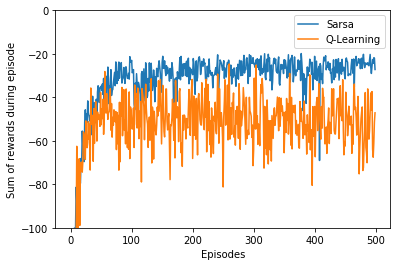

Sarsa Optimal Policy:
['D', 'L', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'D']
['R', 'R', 'U', 'U', 'U', 'R', 'R', 'R', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'L', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['L', 'R', 'R', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'D', 'D']
['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


In [4]:
figure_6_4()

由上图可以看出， Q-learning 学习了最优策略，但是智能体偶尔会调入悬崖（因为是贪心探索策略）。

虽然 Q-learning 学到了最优策略的价值，但是在线性性能却比学到迂回策略的 Sarsa 差。但如果 $\epsilon$逐渐减小，那么两种方法都会渐进地收敛到最优策略。

100%|██████████| 10/10 [00:25<00:00,  2.90s/it]


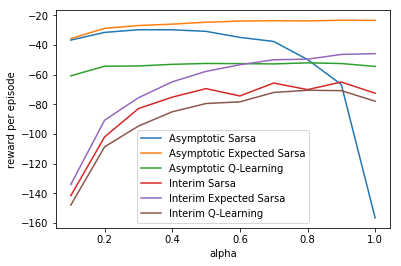

In [5]:
figure_6_6()

### Example 6.7: Maximization Bias Example

The small MDP shown inset in Figure provides a simple example of how maximization bias can harm the performance of TD control algorithms. The MDP has two non-terminal states A and B. Episodes always start in A with a choice between two actions, left and right. The right action ransitions immediately to the terminal state with a reward and return of zero. The left action transitions to B, also with a reward of zero, from which here are many possible actions all of which cause immediate termination with a reward drawn from a normal distribution with mean −0.1 and variance 1.0.

![](images/05-05.png)

In [10]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# state A
STATE_A = 0

# state B
STATE_B = 1

# use one terminal state
STATE_TERMINAL = 2

# starts from state A
STATE_START = STATE_A

# possible actions in A
ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.1

# discount for max value
GAMMA = 1.0

# possible actions in B, maybe 10 actions
ACTIONS_B = range(0, 10)

# all possible actions
STATE_ACTIONS = [[ACTION_A_RIGHT, ACTION_A_LEFT], ACTIONS_B]

# state action pair values, if a state is a terminal state, then the value is always 0
INITIAL_Q = [np.zeros(2), np.zeros(len(ACTIONS_B)), np.zeros(1)]

# set up destination for each state and each action
TRANSITION = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(ACTIONS_B)]

# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(STATE_ACTIONS[state])
    else:
        values_ = q_value[state]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

# take @action in @state, return the reward
def take_action(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(-0.1, 1)

# if there are two state action pair value array, use double Q-Learning
# otherwise use normal Q-Learning
def q_learning(q1, q2=None):
    state = STATE_START
    # track the # of action left in state A
    left_count = 0
    while state != STATE_TERMINAL:
        if q2 is None:
            action = choose_action(state, q1)
        else:
            # derive a action form Q1 and Q2
            '''
            zip() 还可用在 [ for ] 中，直接对元素运算 来生成 list()
            '''
            action = choose_action(state, [item1 + item2 for item1, item2 in zip(q1, q2)])
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        reward = take_action(state, action)
        next_state = TRANSITION[state][action]
        if q2 is None:
            active_q = q1
            target = np.max(active_q[next_state])
        else:
            if np.random.binomial(1, 0.5) == 1:
                active_q = q1
                target_q = q2
            else:
                active_q = q2
                target_q = q1
            best_action = np.random.choice([action_ for action_, value_ in enumerate(active_q[next_state]) if value_ == np.max(active_q[next_state])])
            target = target_q[next_state][best_action]

        # Q-Learning update
        active_q[state][action] += ALPHA * (
            reward + GAMMA * target - active_q[state][action])
        state = next_state
    return left_count

# Figure 6.7, 1,000 runs may be enough, # of actions in state B will also affect the curves
def figure_6_7():
    # each independent run has 300 episodes
    episodes = 300
    runs = 1000
    left_counts_q = np.zeros((runs, episodes))
    left_counts_double_q = np.zeros((runs, episodes))
    for run in tqdm(range(runs)):
        q = copy.deepcopy(INITIAL_Q)
        q1 = copy.deepcopy(INITIAL_Q)
        q2 = copy.deepcopy(INITIAL_Q)
        for ep in range(0, episodes):
            left_counts_q[run, ep] = q_learning(q)
            left_counts_double_q[run, ep] = q_learning(q1, q2)
    left_counts_q = left_counts_q.mean(axis=0)
    left_counts_double_q = left_counts_double_q.mean(axis=0)

    plt.plot(left_counts_q, label='Q-Learning')
    plt.plot(left_counts_double_q, label='Double Q-Learning')
    plt.plot(np.ones(episodes) * 0.05, label='Optimal')
    plt.xlabel('episodes')
    plt.ylabel('% left actions from A')
    plt.legend()

    plt.show()

100%|██████████| 1000/1000 [00:24<00:00, 40.57it/s]


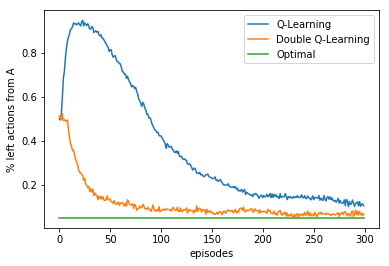

In [11]:
figure_6_7()

实验结果证明，相比Q学习，双Q学习是有效的。